<div style=" background-color: purple;" >
<h2 style="margin: auto; padding: 20px 0; color:0000; text-align: center">Prédire la survie des passagers du Titanic
</h2>
</div>

###  Chargement des bibliothèques

In [296]:
import pandas as pd

import seaborn as sns
titanic = sns.load_dataset('titanic')

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


| Colonne        | Signification                                                                 |
|----------------|--------------------------------------------------------------------------------|
| `survived`     | 1 = survécu, 0 = décédé                                                        |
| `pclass`       | Classe du billet (1ère, 2e, 3e classe)                                         |
| `sex`          | Sexe de la personne (`male` ou `female`)                                      |
| `age`          | Âge de la personne                                                             |
| `sibsp`        | Nombre de frères/sœurs ou conjoints à bord                                     |
| `parch`        | Nombre de parents ou enfants à bord                                            |
| `fare`         | Tarif du billet payé                                                           |
| `embarked`     | Port d’embarquement (`C` = Cherbourg, `Q` = Queenstown, `S` = Southampton)     |
| `class`        | Classe sous forme textuelle (`First`, `Second`, `Third`)                      |
| `who`          | Type de personne (`man`, `woman`, `child`) basé sur l’âge et le sexe          |
| `adult_male`   | Booléen : est-ce un homme adulte (`True` ou `False`)                          |
| `deck`         | Pont sur lequel était la cabine (`A`, `B`, ..., `NaN` = inconnu)              |
| `embark_town`  | Ville d’embarquement en toutes lettres (`Cherbourg`, `Southampton`, ...)      |
| `alive`        | Statut (`yes` pour vivant, `no` pour décédé)                                  |
| `alone`        | Booléen : voyageait-il seul ? (`True` ou `False`)                             |


In [299]:
titanic.head(6)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True


In [301]:
ligne, colonne = titanic.shape
print(f" Le nombre de ligne(s) : {ligne} et colonne(s) : {colonne} ")

 Le nombre de ligne(s) : 891 et colonne(s) : 15 


### ANALYSE UNIVARIES

In [304]:
dtype_summary = pd.DataFrame({
    'column': titanic.columns,
    'dtype': titanic.dtypes,
    'n_missing': titanic.isna().sum(),
    'n_unique': titanic.nunique(dropna=False)
})
print(dtype_summary)

                  column     dtype  n_missing  n_unique
survived        survived     int64          0         2
pclass            pclass     int64          0         3
sex                  sex    object          0         2
age                  age   float64        177        89
sibsp              sibsp     int64          0         7
parch              parch     int64          0         7
fare                fare   float64          0       248
embarked        embarked    object          2         4
class              class  category          0         3
who                  who    object          0         3
adult_male    adult_male      bool          0         2
deck                deck  category        688         8
embark_town  embark_town    object          2         4
alive              alive    object          0         2
alone              alone      bool          0         2


Colonnes avec beaucoup de valeurs manquantes :

age (177 valeurs manquantes)

deck (688 valeurs manquantes) colonne suseptible à biaisé le  modèle !

Colonnes catégorielles intéressantes :

sex, embarked, class, who, alive, embark_town utiles pour le feature engineering ou un encodage LabelEncoder ou OneHotEncoder.

Colonnes avec peu de variabilité :

survived, sex, adult_male, alive, alone  souvent des booléens ou binaires.

Colonnes numériques continues :

age et fare  utiles pour la conception du modèles de machine learning.

## La parité d'homme, de femme et d'enfants à bord 

In [308]:
# Encodage temporaire si ce n’est pas déjà fait
titanic['sex'] = titanic['sex'].map({'male': 1, 'female': 0})

# Comptage hommes et femmes
nb_hommes = titanic[titanic['sex'] == 1].shape[0]
nb_femmes = titanic[titanic['sex'] == 0].shape[0]

# Comptage enfants (moins de 10 ans)
nb_bebes = titanic[titanic['age'] < 10].shape[0]

print(f"Nombre d'hommes à bord : {nb_hommes}")
print(f"Nombre de femmes à bord : {nb_femmes}")
print(f"Nombre de enfants à bord (âge < 10 ans) : {nb_bebes}")
#print(f"Nombre total de passagers à bords : {titanic.shape[0]}")


Nombre d'hommes à bord : 577
Nombre de femmes à bord : 314
Nombre de enfants à bord (âge < 10 ans) : 62


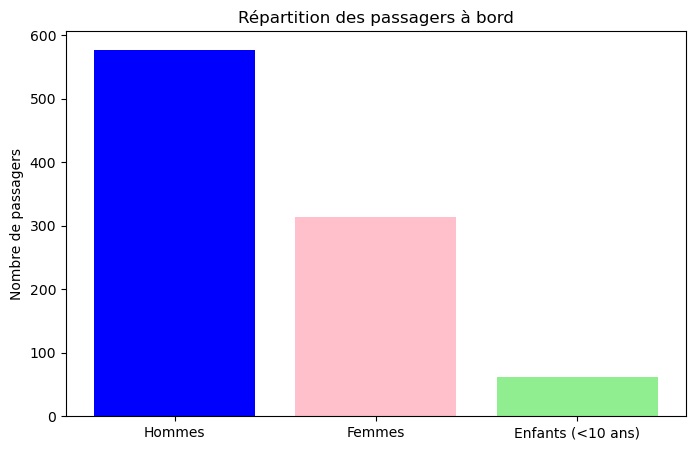

In [310]:
# Préparer les données pour le graphique
labels = ['Hommes', 'Femmes', 'Enfants (<10 ans)']
counts = [nb_hommes, nb_femmes, nb_bebes]
colors = ['blue', 'pink', 'lightgreen']

# Affichage du graphique
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors)
plt.title("Répartition des passagers à bord")
plt.ylabel("Nombre de passagers")
plt.show()


#### Repartition des passagers par port d'embarquement

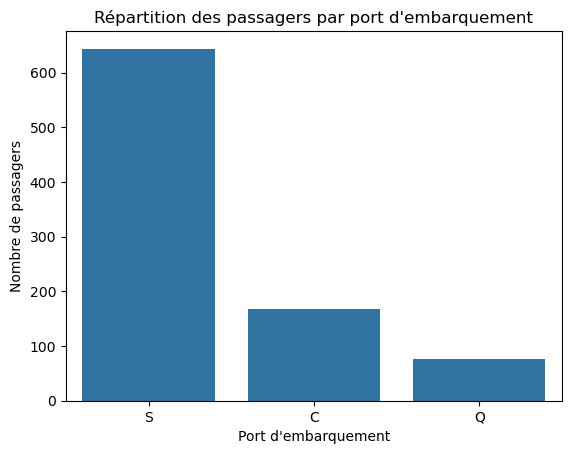

In [313]:
sns.countplot(x='embarked', data=titanic, order=titanic['embarked'].value_counts().index)
plt.title("Répartition des passagers par port d'embarquement")
plt.xlabel("Port d'embarquement")
plt.ylabel("Nombre de passagers")
plt.show()


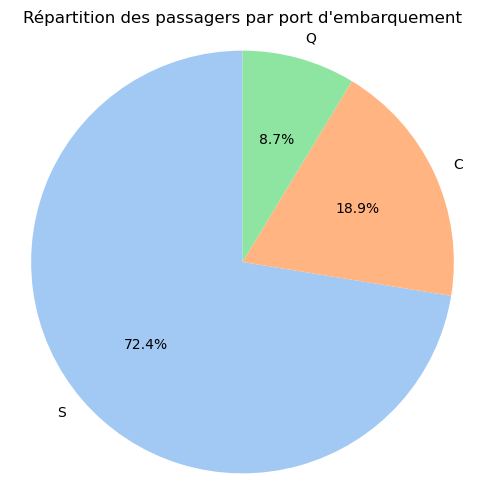

In [315]:
embarked_counts = titanic['embarked'].value_counts()
labels = embarked_counts.index
sizes = embarked_counts.values

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Répartition des passagers par port d'embarquement")
plt.axis('equal')  # Cercle parfait
plt.show()


### Visualisation des âges des passagers à bord

--- age ---
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64 



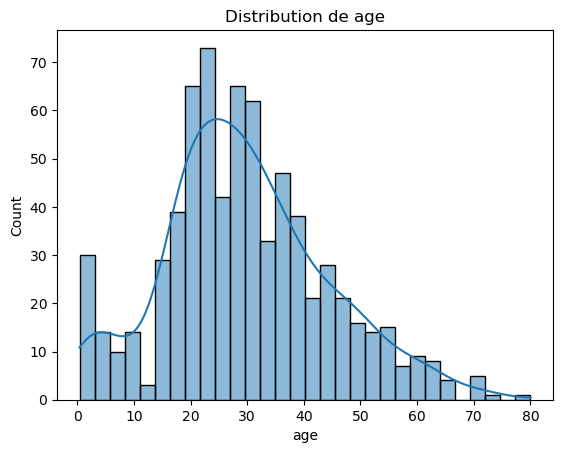

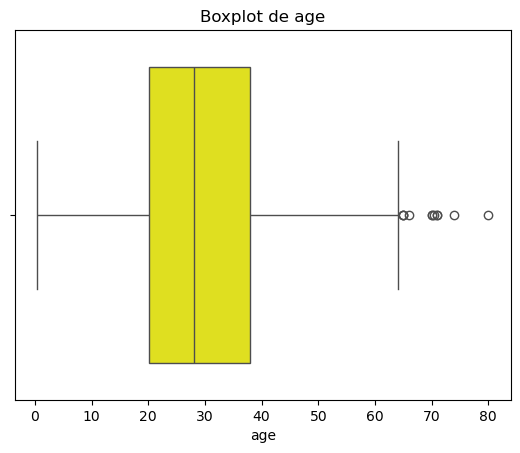

--- fare ---
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64 



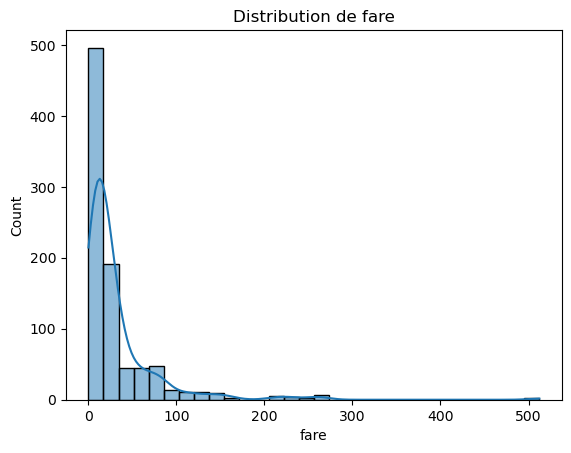

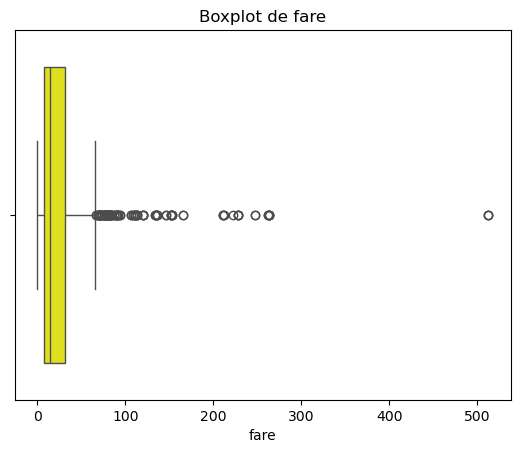

In [318]:
for col in ['age', 'fare']:
    print(f"--- {col} ---")
    print(titanic[col].describe(), '\n')
    # Histogramme + densité
    plt.figure()
    sns.histplot(titanic[col], kde=True, bins=30)
    plt.title(f'Distribution de {col}')
    plt.show()
    # Boxplot
    plt.figure()
    sns.boxplot(x=titanic[col], color="yellow")
    plt.title(f'Boxplot de {col}')
    plt.show()

### 1. **Données sur l'âge**
- **Boxplot de l'âge** : Le boxplot montre une médiane autour de 28 ans, avec un interquartile (IQR) allant de 20 à 38 ans. Il y a des valeurs aberrantes (outliers) au-delà de 60 ans, indiquant que certains âges sont nettement plus élevés que la majorité.
- **Histogramme de l'âge** : La distribution est asymétrique, avec un pic autour de 20-30 ans, et une décroissance progressive après 40 ans. Cela suggère que la plupart des individus sont jeunes, avec peu de personnes âgées.
- **Statistiques** :
  - **Moyenne** : 29.7 ans (proche de la médiane, indiquant une distribution relativement symétrique au centre).
  - **Écart-type** : 14.5, montrant une dispersion modérée.
  - **Min** : 0.4 ans (des nourrissons).
  - **Max** : 80 ans (cohérent avec les outliers).
  - La majorité des âges se concentrent entre 20 et 38 ans.

### 2. **Données sur le tarif (fare)**
- **Boxplot du tarif** : La médiane est autour de 14.5, avec un IQR de 7.9 à 31. Les outliers commencent après 50 et vont jusqu'à 512, indiquant des tarifs très élevés pour quelques cas.
- **Histogramme du tarif** : La distribution est fortement asymétrique, avec un pic autour de 0-50, et une queue longue vers les valeurs élevées. La plupart des tarifs sont bas, avec quelques exceptions coûteuses.
- **Statistiques** :
  - **Moyenne** : 32.3 (supérieure à la médiane, due aux outliers élevés).
  - **Écart-type** : 49.6, indiquant une grande variabilité.
  - **Min** : 0 (tarifs gratuits possibles).
  - **Max** : 512 (tarif exceptionnel).

### Interprétation générale
- **Âge** : La population est principalement jeune (20-38 ans), avec quelques cas extrêmes (enfants ou personnes âgées). La distribution est légèrement asymétrique à droite.
- **Tarif** : La majorité des tarifs sont bas (7.9-31), mais il existe des valeurs aberrantes élevées, suggérant des cas spécifiques (par exemple, voyages de luxe ). La distribution est fortement asymétrique à droite.
- **Relation potentielle** : Sans données croisées, on ne peut pas conclure, mais les outliers dans les deux variables pourraient indiquer des cas particuliers (personnes âgées payant des tarifs élevés).

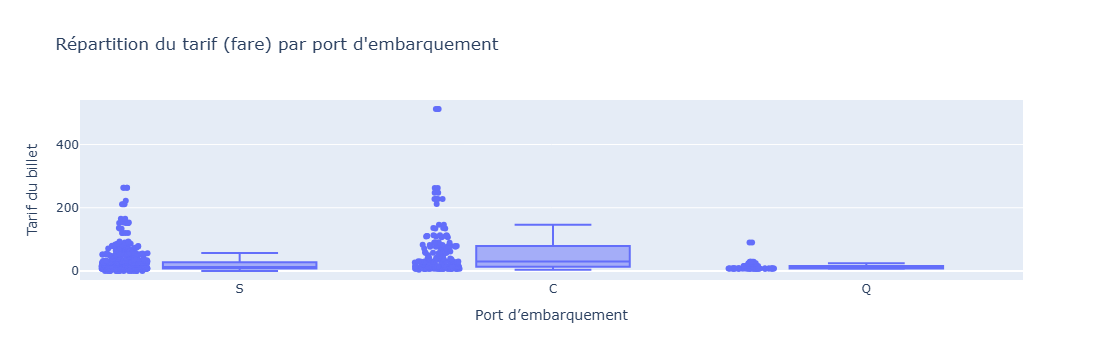

In [320]:
import plotly.express as px

# 2. Nettoyer les NaN sur 'embarked' et 'fare' si nécessaire
df_plot = titanic.dropna(subset=['embarked', 'fare'])

# 3. Créer le boxplot
fig = px.box(
    df_plot,
    x='embarked',      # axe des catégories
    y='fare',          # variable numérique
    points='all',      # affiche aussi tous les points (optionnel)
    title='Répartition du tarif (fare) par port d\'embarquement',
    labels={
        'embarked': 'Port d’embarquement',
        'fare': 'Tarif du billet'
    }
)


fig.show()

<Axes: xlabel='embarked', ylabel='fare'>

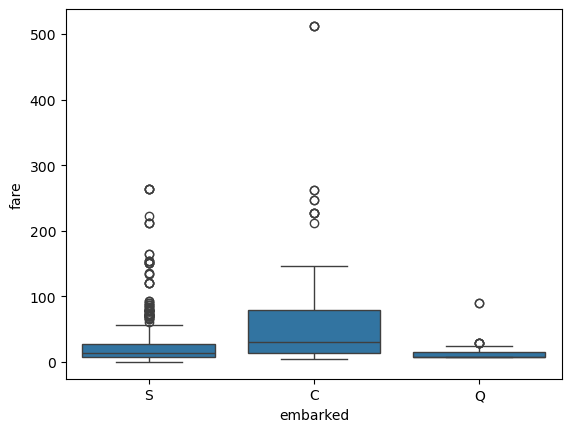

In [322]:
sns.boxplot(data=titanic,x='embarked',y='fare')

<Axes: xlabel='pclass', ylabel='fare'>

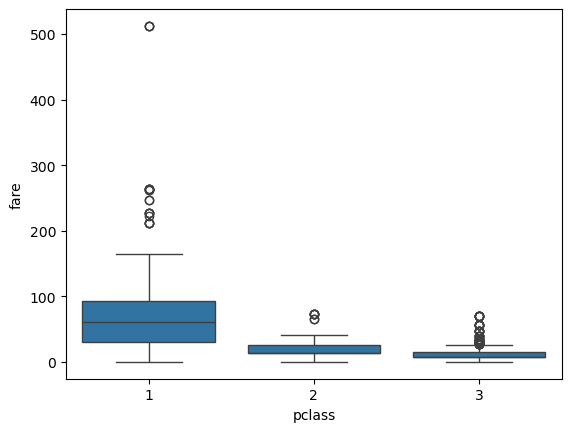

In [324]:
sns.boxplot(data=titanic,x='pclass',y='fare')

In [327]:
def Affichage_des_outliers(df, colonne):
    q1 = df[colonne].quantile(0.25)
    
    q3 = df[colonne].quantile(0.75)
    
    IQR = q3 - q1

    borne_inf = q1 - 1.5 * IQR
    borne_sup = q3 + 1.5 * IQR
    return (df[colonne] < borne_inf) | (df[colonne] > borne_sup)

In [329]:
s = Affichage_des_outliers(titanic,'age')
titanic[s]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
33,0,2,1,66.0,0,0,10.5000,S,Second,man,True,NaN,Southampton,no,True
54,0,1,1,65.0,0,1,61.9792,C,First,man,True,B,Cherbourg,no,False
96,0,1,1,71.0,0,0,34.6542,C,First,man,True,A,Cherbourg,no,True
116,0,3,1,70.5,0,0,7.7500,Q,Third,man,True,NaN,Queenstown,no,True
280,0,3,1,65.0,0,0,7.7500,Q,Third,man,True,NaN,Queenstown,no,True
456,0,1,1,65.0,0,0,26.5500,S,First,man,True,E,Southampton,no,True
493,0,1,1,71.0,0,0,49.5042,C,First,man,True,NaN,Cherbourg,no,True
630,1,1,1,80.0,0,0,30.0000,S,First,man,True,A,Southampton,yes,True
672,0,2,1,70.0,0,0,10.5000,S,Second,man,True,NaN,Southampton,no,True
745,0,1,1,70.0,1,1,71.0000,S,First,man,True,B,Southampton,no,False


In [331]:
s = Affichage_des_outliers(titanic,'fare')
titanic[s]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,0,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
27,0,1,1,19.0,3,2,263.0000,S,First,man,True,C,Southampton,no,False
31,1,1,0,NaN,1,0,146.5208,C,First,woman,False,B,Cherbourg,yes,False
34,0,1,1,28.0,1,0,82.1708,C,First,man,True,NaN,Cherbourg,no,False
52,1,1,0,49.0,1,0,76.7292,C,First,woman,False,D,Cherbourg,yes,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,0,3,1,NaN,8,2,69.5500,S,Third,man,True,NaN,Southampton,no,False
849,1,1,0,NaN,1,0,89.1042,C,First,woman,False,C,Cherbourg,yes,False
856,1,1,0,45.0,1,1,164.8667,S,First,woman,False,NaN,Southampton,yes,False
863,0,3,0,NaN,8,2,69.5500,S,Third,woman,False,NaN,Southampton,no,False


- Detection des valeurs nulles

In [334]:
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

- Une copie de la BD et Récupération des colonnes utiles

In [337]:
df = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].copy()

- Remplacement des valeurs nulles trouvées parmi les âges par la médiane 

In [340]:
mediane_age = df['age'].median()
print(f"La mediane de l'age : {mediane_age} ans")

La mediane de l'age : 28.0 ans


In [342]:
df['age'] = df['age'].fillna(mediane_age)

- Remplacement des valeurs nulles parmi les modes d'embarquement par le mode

In [345]:
mode_embarked = df['embarked'].mode()[0]
print(f" Le mode de la colonne embarked est : {mode_embarked} ")

 Le mode de la colonne embarked est : S 


In [347]:
df['embarked'] = df['embarked'].fillna(mode_embarked)

- Vérification des valeurs nulles 

In [350]:
df.isnull().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

- Correlation

In [353]:
df_numerique = df.select_dtypes(include=['number'])

<Axes: >

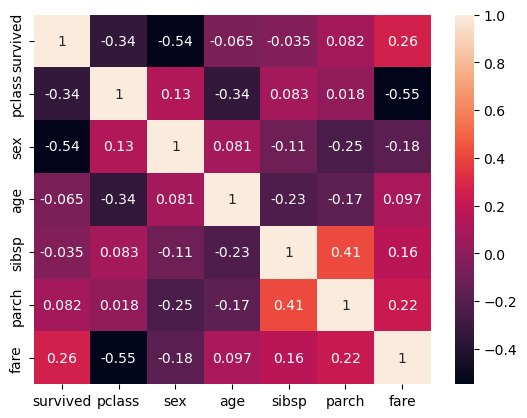

In [355]:
sns.heatmap(df_numerique.corr() ,annot=True)

In [356]:
df.corr(numeric_only=True)['survived'].sort_values(ascending=True)

sex        -0.543351
pclass     -0.338481
age        -0.064910
sibsp      -0.035322
parch       0.081629
fare        0.257307
survived    1.000000
Name: survived, dtype: float64

In [357]:
df.head(4)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S


- Le nombre de passagers par rapport à la zone d'embarquement

In [362]:
df['embarked'].value_counts()

embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [364]:
# Comptage hommes et femmes
nb_hommes = df[df['sex'] == 1].shape[0]
nb_femmes = df[df['sex'] == 0].shape[0]

# Comptage enfants (moins de 10 ans)
nb_bebes = df[df['age'] < 10].shape[0]

print(f"Nombre d'hommes à bord : {nb_hommes}")
print(f"Nombre de femmes à bord : {nb_femmes}")
print(f"Nombre de enfants à bord (âge < 10 ans) : {nb_bebes}")

Nombre d'hommes à bord : 577
Nombre de femmes à bord : 314
Nombre de enfants à bord (âge < 10 ans) : 62


In [366]:
df = pd.get_dummies(df , columns=['embarked'], drop_first=True)

In [368]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked_Q,embarked_S
0,0,3,1,22.0,1,0,7.2500,False,True
1,1,1,0,38.0,1,0,71.2833,False,False
2,1,3,0,26.0,0,0,7.9250,False,True
3,1,1,0,35.0,1,0,53.1000,False,True
4,0,3,1,35.0,0,0,8.0500,False,True
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,False,True
887,1,1,0,19.0,0,0,30.0000,False,True
888,0,3,0,28.0,1,2,23.4500,False,True
889,1,1,1,26.0,0,0,30.0000,False,False


# Proportions des survivants du titanic

```python
pour rappel 0=female 1=male

Text(0.5, 1.0, 'Taux de survie par sexe')

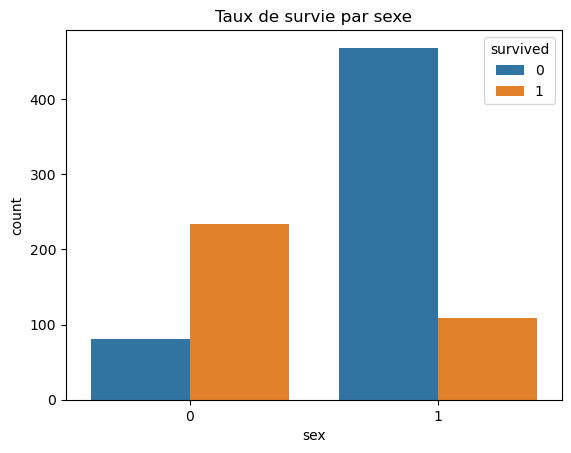

In [372]:
sns.countplot(data=df, x='sex', hue='survived')
plt.title("Taux de survie par sexe")


- Donc nous avons ....

In [375]:
woman = df[(df['sex'] == 0) & (df['survived'] == 1)] 
man = df[(df['sex'] == 1) & (df['survived'] == 1)]
print(man.shape[0],"Hommes ont survécu au nofrage du Titanic")
print(woman.shape[0],"Femmes ont survécu au nofrage du Titanic")

109 Hommes ont survécu au nofrage du Titanic
233 Femmes ont survécu au nofrage du Titanic


- soit ...

In [378]:
# Calcul du pourcentage de survie par sexe
pourcentages = df.groupby('sex')['survived'].value_counts(normalize=True).unstack() * 100

# Pourcentage de survie pour chaque sexe
hommes_survies = pourcentages.loc[1, 1]
femmes_survies = pourcentages.loc[0, 1] 

print(f"{hommes_survies:.2f} % des passagers hommes ont survécu")
print(f"{femmes_survies:.2f} % des passagers femmes ont survécu")


18.89 % des passagers hommes ont survécu
74.20 % des passagers femmes ont survécu


<div style=" background-color: pink;" >
<h2 style="margin: auto; padding: 20px 0; color:black; text-align: center"> Création du Modèle de Machine Learning
</h2>
</div>

- Séparation des données 

In [382]:
x = df.drop(columns= ['survived'], axis= 1 )
y = df['survived']

In [384]:
X_train , X_test , Y_train , Y_test = train_test_split (x , y , test_size=0.2 , random_state= 42 )

## Mise à l'echelle
à quoi ça sert ? 

```python 
La mise à l echelle est une étape de préparation des données, qui consiste à ramener toutes les colonnes numériques sur une échelle comparable.

In [387]:
scaler = StandardScaler()

In [389]:
x_train_scaler = scaler.fit_transform(X_train) 
x_test_scaler = scaler.transform(X_test)
# x_test_scaler = scaler.fit_transform(X_test) #Erreur fréquente ici : tu ne dois pas "fit" sur le test. Tu dois utiliser le même scaler que pour X_train.

In [391]:
x_train_scaler_df = pd.DataFrame(x_train_scaler  , columns = X_train.columns , index = X_train.index )
x_test_scaler_df = pd.DataFrame(x_test_scaler , columns= X_test.columns , index = X_test.index )

In [393]:
model = LogisticRegression()

In [395]:
model.fit(x_train_scaler_df, Y_train)

LogisticRegression()

In [397]:
print(model.coef_)

[[-0.78532758 -1.27710362 -0.39615158 -0.34995217 -0.09614164  0.12651098
  -0.04605838 -0.18942319]]


In [399]:
prediction = model.predict(x_test_scaler_df)

- Importation des metriques 

In [402]:
from sklearn.metrics import accuracy_score , precision_score , recall_score ,f1_score , ConfusionMatrixDisplay , confusion_matrix

- Pourcentage de prédiction correcte

In [405]:
accuracy = accuracy_score(Y_test ,prediction) * 100
print(f"{accuracy:.2f} % de prediction correcte ")

81.01 % de prediction correcte 


- Parmi tous les cas prévus comme positifs (1), combien sont vraiment positifs ?

In [408]:
precision = precision_score(Y_test ,prediction)*100
print(f"{precision:.2f} % de précision ")

78.57 % de précision 


- Parmi tous les vrais positifs, combien le modèle a su identifier ?

In [411]:
recall = recall_score(Y_test ,prediction)*100
print(f"{recall:.2f} % de vrais identifiés ")

74.32 % de vrais identifiés 


- Moyenne harmonique entre précision et rappel.

In [414]:
F1 = f1_score(Y_test ,prediction )*100
print(f"{F1:.2f} % de vrais identifiés ")

76.39 % de vrais identifiés 


- La matrice de confusion

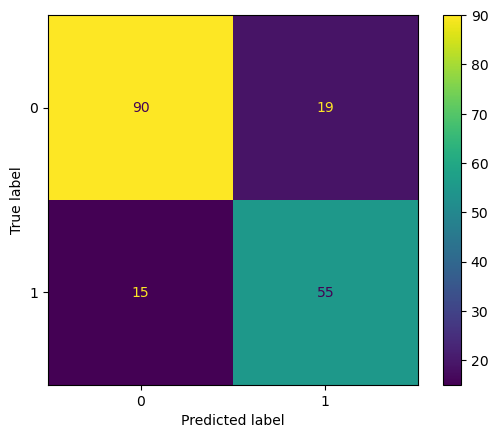

In [417]:
ConfusionMatrixDisplay.from_predictions(prediction,Y_test)

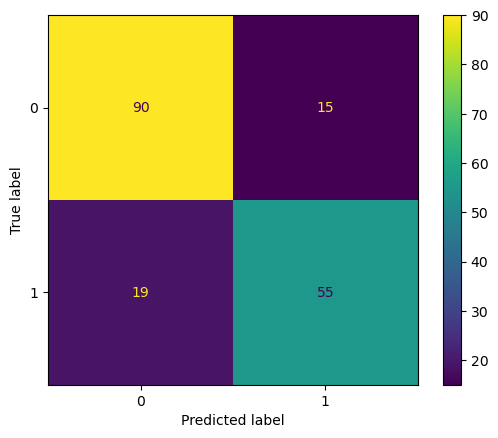

In [419]:
ConfusionMatrixDisplay.from_estimator( model , x_test_scaler_df , Y_test )

## Que retenir ?

- 92 passagers ont bien été trouvés comme non survivants

- 53 passagers ont bien été trouvés comme survivants

- 21 passagers ont survecus mais ont été marqués comme décédés 

- 13 passagers n'ont pas survécus mais ont été marqués comme survivants

#### LA COURBE ROC

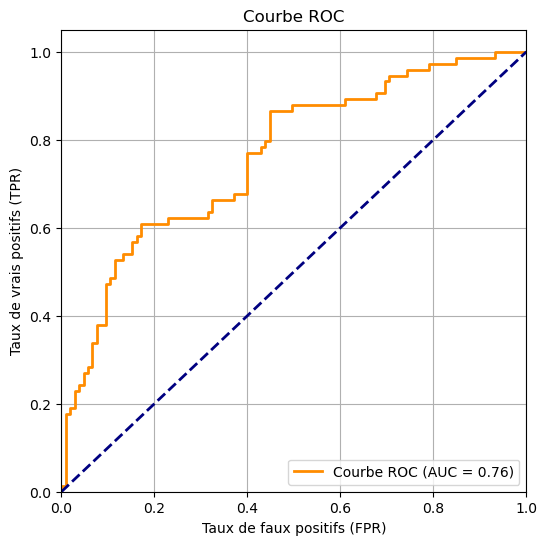

In [423]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilités prédites (seulement la proba de la classe positive)
y_proba = model.predict_proba(X_test)[:, 1]  # ou pipe_rf.predict_proba(X_test)[:, 1]

# Calcul des courbes ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

- 1. Présentation de la courbe ROC

la courbe ROC (Receiver Operating Characteristic) de notre Régression Logistique trace le Taux de vrais positifs TPR en fonction du Taux de faux positifs FPR , pour l’ensemble des seuils de décision possibles.

- 2. Analyse de l’AUC

L’aire sous la courbe (AUC) vaut 0,76 signalant une bonne capacité du modèle à distinguer les passagers survivants des non‑survivants, mais laisse de la marge pour un affinage.

In [426]:
# Supprimer les lignes avec des données manquantes pour 'fare' ou 'embarked'
titanic_ = titanic.dropna(subset=['fare', 'embarked', 'pclass'])

# Transformer 'embarked' en string
titanic_['embarked'] = titanic['embarked'].astype(str)

# Calcul des quantiles 5% - 95% pour limiter l'effet des outliers
fare_ranges = (
    titanic.groupby(['pclass', 'embarked'])['fare']
    .quantile([0.05, 0.95])
    .unstack()
    .rename(columns={0.05: 'min_fare', 0.95: 'max_fare'})
    .reset_index()
)

# Convertir en dictionnaire utilisable
fare_dict = {
    (int(row.pclass), row.embarked): (round(row.min_fare, 2), round(row.max_fare, 2))
    for _, row in fare_ranges.iterrows()
}


C:\Users\hp\AppData\Local\Temp\ipykernel_5536\4049946678.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [433]:
def prediction_titanic():
    print("🎯 Simulation : Auriez-vous survécu au Titanic ?\n")

    # Entrée utilisateur
    pclass = int(input("Classe (1 = 1ère, 2 = 2e, 3 = 3e) : "))
    sex = int(input("Sexe (homme = 1, femme = 0) : "))
    age = float(input("Âge : "))
    sibsp = int(input("Nombre de frères/soeurs à bord : "))
    parch = int(input("Nombre de parents/enfants à bord : "))

    # Port d’embarquement
    embark = ""
    while embark not in ['C', 'Q', 'S']:
        embark = input("Port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton) : ").upper()

    # Vérification dynamique des prix
    min_fare, max_fare = fare_dict.get((pclass, embark), (0, 600))
    while True:
        fare = float(input(f"Prix du billet (entre {min_fare}£ et {max_fare}£ pour cette classe et ce port) : "))
        if min_fare <= fare <= max_fare:
            break
        print("❌ Prix incohérent avec la classe et le port. Réessayez.\n")

    # Encodage embarquement
    embarked_Q = 1 if embark == 'Q' else 0
    embarked_S = 1 if embark == 'S' else 0

    # Préparation DataFrame utilisateur
    infos = {
        'pclass': pclass,
        'sex': sex,
        'age': age,
        'sibsp': sibsp,
        'parch': parch,
        'fare': fare,
        'embarked_Q': embarked_Q,
        'embarked_S': embarked_S
    }

    user_df = pd.DataFrame([infos])

    # Standardisation + Prédiction
    user_scaled = scaler.transform(user_df)
    result = model.predict(user_scaled)[0]

    # Affichage du verdict
    print("\n🎓 Résultat de la simulation :")
    if result == 1:
        print("✅ Vous auriez survécu au Titanic !")
    else:
        print("❌ Vous n'auriez pas survécu...")


In [435]:
prediction_titanic()

🎯 Simulation : Auriez-vous survécu au Titanic ?



Classe (1 = 1ère, 2 = 2e, 3 = 3e) :  1
Sexe (homme = 1, femme = 0) :  1
Âge :  25
Nombre de frères/soeurs à bord :  1
Nombre de parents/enfants à bord :  2
Port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton) :  C
Prix du billet (entre 27.73£ et 259.4£ pour cette classe et ce port) :  40



🎓 Résultat de la simulation :
❌ Vous n'auriez pas survécu...


	survived	pclass	sex	age	sibsp	parch	fare	embarked_Q	embarked_S

In [429]:
def prediction_titanic():
    print("🎯 Simulation : Auriez-vous survécu au Titanic ?\n")

    # Entrée utilisateur
    pclass = int(input("Classe (1 = 1ère, 2 = 2e, 3 = 3e) : "))
    sex = int(input("Sexe (homme = 1, femme = 0) : "))
    age = float(input("Âge : "))
    sibsp = int(input("Nombre de frères/soeurs à bord : "))
    parch = int(input("Nombre de parents/enfants à bord : "))

    # Port d’embarquement
    embark = ""
    while embark not in ['C', 'Q', 'S']:
        embark = input("Port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton) : ").upper()

    # Vérification dynamique des prix
    min_fare, max_fare = fare_dict.get((pclass, embark), (0, 600))
    while True:
        fare = float(input(f"Prix du billet (entre {min_fare}£ et {max_fare}£ pour cette classe et ce port) : "))
        if min_fare <= fare <= max_fare:
            break
        print("❌ Prix incohérent avec la classe et le port. Réessayez.\n")

    # Encodage embarquement
    embarked_Q = 1 if embark == 'Q' else 0
    embarked_S = 1 if embark == 'S' else 0

    # Préparation DataFrame utilisateur
    infos = {
        'pclass': pclass,
        'sex': sex,
        'age': age,
        'sibsp': sibsp,
        'parch': parch,
        'fare': fare,
        'embarked_Q': embarked_Q,
        'embarked_S': embarked_S
    }

    user_df = pd.DataFrame([infos])

    # Standardisation + Prédiction
    user_scaled = scaler.transform(user_df)
    result = model.predict(user_scaled)[0]

    # Affichage du verdict
    print("\n🎓 Résultat de la simulation :")
    if result == 1:
        print("✅ Vous auriez survécu au Titanic !")
    else:
        print("❌ Vous n'auriez pas survécu...")


In [ ]:
prediction_logistique()

Simulation : auriez-vous survécu au Titanic ?



#### RANDOM FOREST

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Créaation du Model

In [165]:
# Pipeline = scaler + modèle
Model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])


### Entrainement du Model

In [170]:
Model.fit(X_train, Y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

###  Évaluation du modèle

In [179]:
y_pred = Model.predict(X_test)
print("Rapport de classification :")
print(classification_report(Y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



##  Contexte global

Pour évaluer l'efficacité du model, on regarde plusieurs indicateurs :

* **Accuracy (Précision globale)**
* **Precision**, **Recall**, et **F1‑score** pour chaque classe
* **Support** (nombre d’exemples réels dans chaque classe)



##  Accuracy : 81 %

* Sur **179** passagers de l’ensemble de test, le modèle a **bien classé 81 %** d’entre eux.
* En termes simples : sur 100 passagers, il devine correctement la survie (ou le décès) pour 81 d’entre eux.





###  Classe “0 = non‑survécu”

* **Precision 83 %**
  → **Parmi tous les passagers** que le modèle a prédits **“n’a pas survécu”**, **83 %** l’étaient effectivement.
* **Recall 86 %**
  → **Parmi tous les passagers** qui **n’ont pas survécu**, le modèle en a correctement identifié **86 %**.
* **F1‑score 84 %**
  → C’est une moyenne harmonique (équilibre) de precision et recall, ici **84 %**, indicateur global de qualité pour cette classe.

### Classe “1 = survécu”

* **Precision 79 %**
  → **Parmi tous les passagers** que le modèle a prédits **“a survécu”**, **79 %** l’ont réellement fait.
* **Recall 74 %**
  → **Parmi tous les passagers** qui **ont réellement survécu**, le modèle en a capté **74 %**.
* **F1‑score 76 %**
  → Moyenne harmonique de precision et recall, soit **76 %** pour la classe “survécu”.



##  Moyennes

* **Macro avg** (moyenne simple des deux classes) : Precision 81 %, Recall 80 %, F1 80 %.
* **Weighted avg** (moyenne pondérée par le nombre d’exemples) : Precision 81 %, Recall 81 %, F1 81 %.

Ces moyennes confirment que, globalement, le modèle atteint environ **80 %** de performance, qu’on regarde les deux classes également ou en tenant compte de leur fréquence.



#### Conclusion

* **81 % des prédictions** sont correctes.
* Le modèle est **un peu meilleur** pour repérer ceux qui **n’ont pas survécu** (Recall 86 %) que pour trouver tous ceux qui **ont survécu** (Recall 74 %).
* Parmi ceux qu’il dit avoir survécu, **79 %** l’ont vraiment fait (Precision).
* Le **F1‑score** combine ces deux idées pour donner un seul chiffre :

  * **84 %** de qualité pour détecter “non‑survécu”,
  * **76 %** pour “survécu”.

Globalement, c’est un modèle **fiable à environ 80 %**, avec une petite préférence pour la détection des non‑survivants.


In [181]:
y_proba = Model.predict_proba(X_test)[:, 1]  # pour l’AUC
print("Accuracy :", accuracy_score(Y_test, y_pred))
print("ROC AUC :", roc_auc_score(Y_test, y_proba))

Accuracy : 0.8100558659217877
ROC AUC : 0.8878378378378379


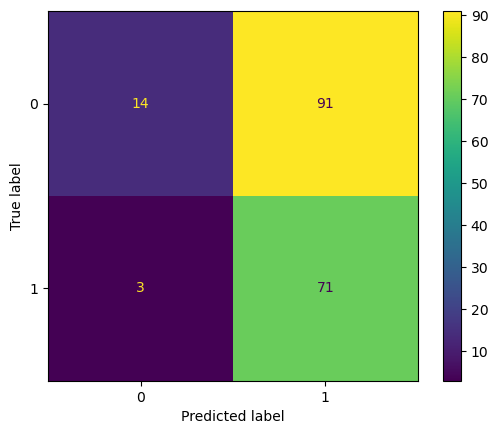

In [218]:
ConfusionMatrixDisplay.from_estimator( Model , x_test_scaler_df , Y_test )

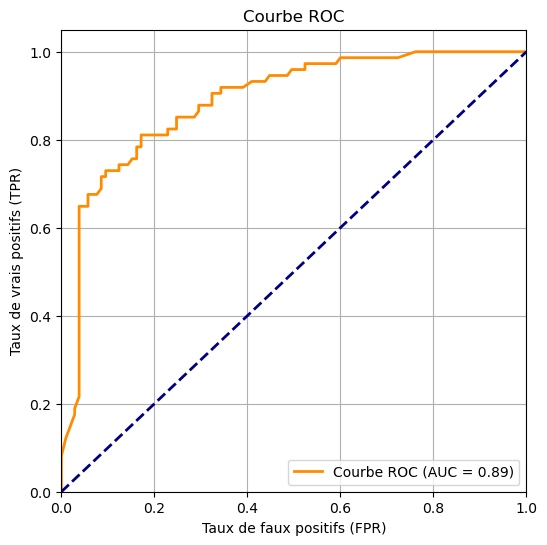

In [247]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilités prédites (seulement la proba de la classe positive)
y_proba = Model.predict_proba(X_test)[:, 1]  # ou pipe_rf.predict_proba(X_test)[:, 1]

# Calcul des courbes ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### La courbe ROC de notre modèle (en orange) se place bien au‑dessus de la diagonale de hasard, avec une AUC de 0,89 : cela montre qu’il différencie de façon très fiable les passagers survivants des non‑survivants. Ainsi, même sans rentrer dans les détails mathématiques, on comprend que plus l’AUC est proche de 1, meilleur est le modèle pour trier correctement les deux catégories.

### Prédiction

In [196]:
def prediction_random_forest():
    print("Simulation : auriez-vous survécu au Titanic ?\n")

    # --- Étape 1 : Entrée utilisateur ---
    pclass = int(input("Classe (1 = 1ère, 2 = 2e, 3 = 3e) : "))
    sex_input = int(input("Sexe (homme = 1, femme = 0) : "))
    age = float(input("Âge : "))
    sibsp = int(input("Nombre de frères/soeurs à bord : "))
    parch = int(input("Nombre de parents/enfants à bord : "))
    fare = float(input("Prix du billet  : "))
    embark = input("Port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton) : ").upper()

    # --- Étape 2 : Transformation manuelle des variables catégorielles ---
    # sex : homme=1, femme=0 → on crée sex_male
    sex_male = 1 if sex_input == 1 else 0

    # embarked : Q et S (on supprime C avec drop_first lors du get_dummies)
    embarked_Q = 1 if embark == 'Q' else 0
    embarked_S = 1 if embark == 'S' else 0

    # --- Étape 3 : Créer le dictionnaire avec toutes les features nécessaires ---
    infos = {
        'pclass': pclass,
        'age': age,
        'fare': fare,
        'sibsp': sibsp,
        'parch': parch,
        'sex_male': sex_male,
        'embarked_Q': embarked_Q,
        'embarked_S': embarked_S
    }

    # --- Étape 4 : Convertir en DataFrame ---
    import pandas as pd
    user_df = pd.DataFrame([infos])

    # --- Étape 5 : Réordonner les colonnes comme dans X (le jeu d'entraînement) ---
    missing_cols = [col for col in X_train.columns if col not in user_df.columns]
    for col in missing_cols:
        user_df[col] = 0  # ajouter les colonnes manquantes si besoin
    user_df = user_df[X_train.columns]  # réorganiser l'ordre des colonnes

    # --- Étape 6 : Prédiction ---
    prediction = Model.predict(user_df)[0]
    proba = Model.predict_proba(user_df)[0][1]

    # --- Étape 7 : Affichage du résultat ---
    if prediction == 1:
        print(f"\n✅ Verdict : Vous auriez survécu au Titanic ! (probabilité = {proba:.2%})")
    else:
        print(f"\n❌ Verdict : Vous n'auriez pas survécu... (probabilité = {proba:.2%})")


In [198]:
prediction_random_forest()

Simulation : auriez-vous survécu au Titanic ?



Classe (1 = 1ère, 2 = 2e, 3 = 3e) :  1
Sexe (homme = 1, femme = 0) :  1
Âge :  25
Nombre de frères/soeurs à bord :  1
Nombre de parents/enfants à bord :  1
Prix du billet  :  250
Port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton) :  C



✅ Verdict : Vous auriez survécu au Titanic ! (probabilité = 90.00%)


### Comparaison des deux modeles

In [203]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dictionnaire pour stocker les résultats
results = {}

for name, model in [('Logistic Regression', model ), ('Random Forest', Model)]:
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    results[name] = {
        'Accuracy' : accuracy_score(Y_test, y_pred),
        'Precision': precision_score(Y_test, y_pred),
        'Recall'   : recall_score(Y_test, y_pred),
        'F1-score' : f1_score(Y_test, y_pred),
        'ROC AUC'  : roc_auc_score(Y_test, y_proba)
    }

# Affichage synthétique
df_res = pd.DataFrame(results).T
print(df_res.round(3))


                     Accuracy  Precision  Recall  F1-score  ROC AUC
Logistic Regression     0.626      0.889   0.108     0.193    0.762
Random Forest           0.810      0.786   0.743     0.764    0.888


<Axes: title={'center': 'Comparaison des modèles'}>

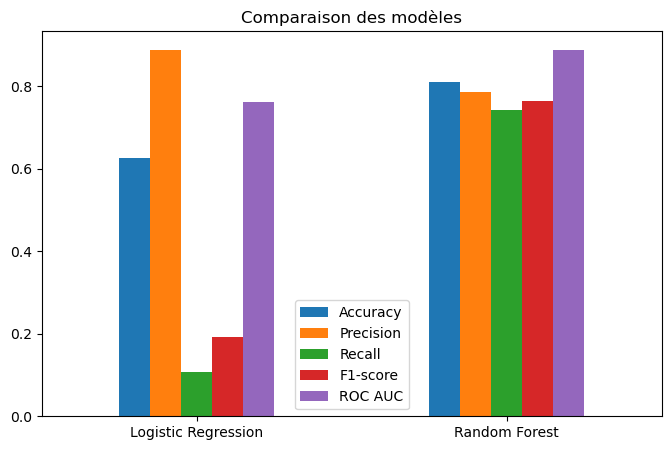

In [205]:
df_res.plot.bar(figsize=(8,5), rot=0, title="Comparaison des modèles")

### Cross validation